# Table of Contents
- [Dynamic Time Patterns for Algorithmic Trading using Machine Learning](#dynamic-time-patterns-for-algorithmic-trading-using-machine-learning)
  - [Setup and Preprocessing](#setup-and-preprocessing)
    - [Environment Setup](#environment-setup)
  - [Math Behind the Algorithm](#math-behind-the-algorithm)
    - [Distance Metrics](#distance-metrics)
    - [K-Nearest Neighbor Algorithm](#k-nearest-neighbor-algorithm)
  - [Simple Backtest of Forecast Predictions](#simple-backtest-of-forecast-predictions)
    - [Backtest Strategy](#backtest-strategy)
  - [Results and Visualization](#results-and-visualization)
  - [Conclusion](#conclusion)

# Dynamic Time Patterns for Algorithmic Trading using machine learning

This project explores time series forecasting in algorithmic trading through KNN clustering with various distance metrics. The objective of the algorithm is to predict market movements or trends based on historical time series data by leveraging KNN clustering with different distance metrics. The primary goal is to achieve the highest accuracy in predicting volatility-adjusted returns, measured using various error metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Normalized Mean Absolute Error (NMAE).

In addition to prediction, a simple backtesting strategy is implemented to evaluate the performance of the algorithm. The backtesting results are assessed using financial metrics such as the Sharpe ratio and maximum drawdown, helping to determine the risk-adjusted return and the overall stability of the strategy in real-world trading conditions.


## Setup and Preprocessing
To run algorithm, import libraries, and initialize data. 

The time-interval used (1-month of data) and the parameters, make the algorithm/predictions take roughly 20 minutes.



### Environnment Setup
Install the required libraries using:

In [74]:
pip install numpy pandas matplotlib fastdtw scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.neighbors import NearestNeighbors
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


### Data Collection
For this project, high-frequency forex data has been used, soruced from Metatrader.

It is downloaded as 1 minute data, which is being changed to 5-minute intervals, where the Closing price of the asset will be used for the return. The data has the Time, Open, High, Low and Closing price.

In the case of the example of the algorithm, the GBP/USD data is used, with the time period March 1, 2021 00:00 to march 31, 2021 23:55.

In [76]:
df = pd.read_csv("gbp_usd_5min.csv", parse_dates=["Time"])

# Sort the index to ensure monotonicity
df.set_index("Time", inplace=True)
df = df.sort_index()

# date-range of data that will be used
start_date = "2021-03-01 00:00"
end_date = "2021-03-31 17:15"

# Define range of df to be used based on dates
df = df.loc[start_date:end_date]

print(df.tail())


                        Open     High      Low    Close
Time                                                   
2021-03-31 16:55:00  1.37838  1.37848  1.37788  1.37791
2021-03-31 17:00:00  1.37792  1.37816  1.37759  1.37809
2021-03-31 17:05:00  1.37808  1.37840  1.37787  1.37787
2021-03-31 17:10:00  1.37802  1.37802  1.37794  1.37795
2021-03-31 17:15:00  1.37795  1.37801  1.37794  1.37798


### data preprocessing

Checking for missing values:

In [77]:
print(df.isna().sum())


Open     0
High     0
Low      0
Close    0
dtype: int64


Logarithmic returns are computed based on closing price at time $t$ divided by closing price at time $t+1$.

In [78]:
df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
df.dropna(inplace=True)

#### Smoothing Returns Using Exponential Moving Average

The returns are smoothed using exponential moving average.
The Exponential Moving Average (EMA) is a weighted moving average that gives more significance to recent data points, making it more responsive to price changes compared to a simple moving average (SMA). 

##### Formula:
$
EMA_t = \alpha \cdot R_t + (1 - \alpha) \cdot EMA_{t-1}
$

where:
- $ EMA_t $ is the exponential moving average at time $ t $,
- $ R_t $ is the return at time \( t \),
- $ \alpha $ is the smoothing factor, calculated as:
  $
  \alpha = \frac{2}{span + 1}
  $
- $ span $ is the chosen period for smoothing.

The smoothing factor $ \alpha $ determines how much weight recent returns receive. A higher $ \alpha $ (lower span) makes the EMA react more to new data, while a lower $ \alpha $ (higher span) results in a smoother curve. [1]

The implementation in python is as followed:

In [79]:
def apply_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

df["ema_returns"] = apply_ema(df["returns"], span=15)
df.dropna(inplace=True)
print(df["ema_returns"].head())

Time
2021-03-01 00:05:00    0.000007
2021-03-01 00:10:00    0.000052
2021-03-01 00:15:00    0.000035
2021-03-01 00:20:00    0.000022
2021-03-01 00:25:00    0.000031
Name: ema_returns, dtype: float64


To validate the function’s correctness (and to show the formula calculation in python), the EMA of return 100 is calculated and compared to the output from apply_ema():

In [80]:
span = 15
EMA_return_100 = 2/(span+1) * df["returns"].iloc[100] + (1 - 2/(span+1)) * df["ema_returns"].iloc[99]
if EMA_return_100 == df.iloc[100]["ema_returns"]:
    print("🎉🎉🎉")
print("Manual EMA:", EMA_return_100)
print("apply_ema() EMA:", df["ema_returns"].iloc[100])

🎉🎉🎉
Manual EMA: -0.00019552803368233756
apply_ema() EMA: -0.00019552803368233756


#### Standardizing EMA Returns Using Rolling Standard Deviation
Standardization is used to normalize data by adjusting for variations in scale and volatility, making it easier to compare values across different time, allowing the detection of regime shifts.

$
\sigma_t = \sqrt{\frac{1}{w} \sum_{i=t-w+1}^{t} (EMA_i - \bar{EMA})^2}
$

where:

- $ \sigma_t $ is the rolling standard deviation at time $ t $,
- $ EMA_i $ are the exponential moving averages within the window,
- $ \bar{EMA} $ is the mean EMA within the window,
- $ w $ is the window size.

standardize the EMA returns:

$
EMA_{std,t} = \frac{EMA_t}{\sigma_t}
$

In this case the window is 120.

The implementation in python is as followed:

In [81]:
window_size = 120
df["rolling_std"] = df["ema_returns"].rolling(window=window_size, min_periods=1).std()
df["rolling_std"] = df["rolling_std"].fillna(df["rolling_std"].mean())
df["std_ema_returns"] = df["ema_returns"] / df["rolling_std"]
df.dropna(inplace=True)


In [82]:
print(df["std_ema_returns"].max())
print(df["std_ema_returns"].min())
print(df["ema_returns"].max())
print(df["ema_returns"].min())

5.335501904526235
-5.087566660043141
0.00045468557104647077
-0.00039797512389973385


Volatility-adjusted, standardized EMA returns roughly range between ±5.

Non-standardized EMA returns are approximately between ±0.0004, which is very low in magnitude.

## Algorithm and Mathematical Foundation

The core of this project is a k-Nearest Neighbors (kNN) model applied to time series forecasting. By identifying the closest historical patterns, one can predict future returns

These predictions accuracy will be assessed using NMAE, comparing the different distance metrics used in KNN.

### Introduction to K-Nearest-Neighbor Algorithm

KNN algorithm is commonly used for classifying data points, but can also be applied to time series forecasting by identifying the most similar past sequences.

KNN works by directly comparing a new data point to historical examples, finding the k most similar instances (neighbors) based on a distance metric, such as Euclidean distance.

Imagine a brokerage firm wants to predict if a new investor is likely to sell their shares of Apple (AAPL) within the next month based on their trading history. They use KNN by looking at a dataset of past investors, where each is represented by a vector of the features: Number of trades in pas 30 days, average holding period, and portfolio size. For a new investor with 5 trades, a 10-day average hold, and a \$10,000 portfolio, KNN finds the 5 most similar past investors. If three of those sold AAPL within a month, the algorithm predicts this new investor is likely to dump their shares too.

In this case, KNN doesn’t rely on clusters or predefined groups—it’s all about proximity in the feature space. The choice of k (here, 5) balances between overfitting (too small a k) and smoothing out patterns (too large a k).



#### K-Means Clustering
A different algorithm, but very much alike, is the K-Means Algorithm. Instead of using a datapoint, finding nearest datapoints, quantifying a classification, centroid will be randomly placed, clustering the data.

A use case of this is Economic Segmentation:
A central bank wants to classify countries based on their economic stability to guide monetary policy decisions. It collects data on:

- GDP Growth Rate (%)

- Inflation Rate (%)

- Unemployment Rate (%)

- Foreign Exchange Reserves (in billion USD)

Using K-Means, the algorithm clusters countries into three economic categories:

1. Stable Economies – Low inflation, steady GDP growth, low unemployment, and high reserves.

2. Emerging Markets – High GDP growth but moderate inflation and unemployment, with moderate forex reserves.

3. Struggling Economies – High unemployment, high inflation, slow GDP growth, and low reserves.

This clustering helps policymakers adjust interest rates, set exchange rate policies, or provide financial aid to struggling economies.

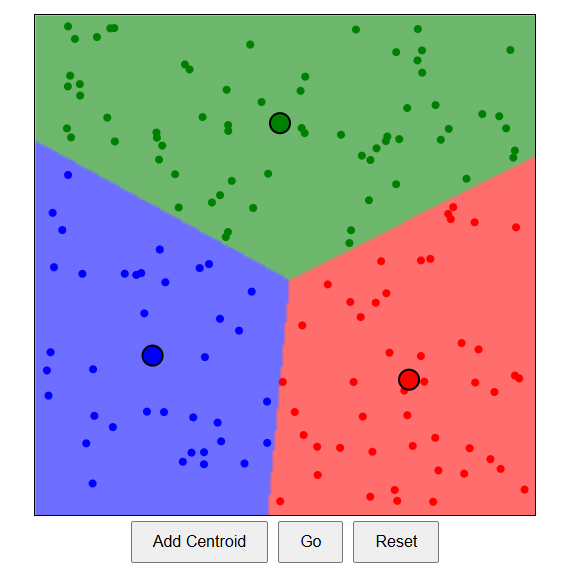

The image above is taken from my project @ https://kristofferjoha.github.io/ClusteringAlgos/, which visualizes the k-means algorithm. (can be slow due to grid resolution)

After having placed centroids, it iterates over the distances and clusters the datapoint, aiming for the shortest avg. distance to each datapoint.

To reference back to K-Nearest-Neighbour, if one imagines that the centroids (black outline) are datapoints in the KNN algorithm. You find the k-nearest datapoints and find the avg. value of what you are trying to predict. In the case of this algorithm, Dynamic Time Patterns, it would be Standardized EMA returns.

### Distance Metrics for Time Series Forecasting with kNN
When using k-Nearest Neighbors (kNN) for time series forecasting, the choice of distance metric is crucial. Since time series data contains temporal dependencies, standard measures like Euclidean distance may not always be effective.

Below are four commonly used distance metrics for comparing time series in forecasting models:

- Euclidean distance

- Dynamic Time Warping (DTW)

- Average Squared Distance (ASD)

- Complexity-Invariant Distance (CID) 

Euclidean distance is the simplest and most commonly used, but more advanced metrics like DTW are better suited when time series exhibit shifts in timing or volatility. [2]

#### Euclidean distance

Euclidean measures the straight-line distance between two sequences of equal length, summing up the squared differences between corresponding points. [3]

##### Formula

Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the euclidean distance between the two time series is:

$$D(X, Y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

Calculating distances between two arrays using euclidean can be implemented in python the following way:

In [83]:
# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])
X_easy = np.array([1, 2])
Y_easy = np.array([4, 6])

def euclidean_distance(X, Y):
    return np.sqrt(np.sum((X - Y) ** 2))

# Eucledean Distance
distance = euclidean_distance(X, Y)
distance_easy = euclidean_distance(X_easy, Y_easy)

print("Euclidean Distance:", distance)
print("Euclidean Distance Pythagoras:", distance_easy)


Euclidean Distance: 4.47213595499958
Euclidean Distance Pythagoras: 5.0


The "Pythagoras" example is included because it is easy to relate to. The distance between the points P(1,2) and P(4,6) is 5, based on the Pythagorean theorem where side lengths 3 and 4 give a hypotenuse length of 5.

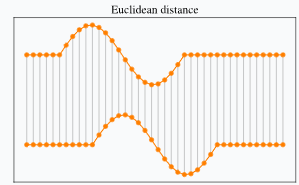

The picture from [4] shows euclidean distance for a time series. It compares each element with the corresponding value. The important thing here is that, as mentioned, the length of the two series must be equal.

#### Dynamic Time Warping (DTW)
DTW is a more flexible measure of distance between two time series, especially when they may be out of phase or have varying lengths. Unlike Euclidean distance, which assumes that the corresponding points in two sequences match up directly, DTW allows for the alignment of time series in a non-linear fashion.

DTW computes the minimum cumulative distance between two sequences by "warping" them to align the most similar points. This is done by comparing each element of one series with several elements of the other series, allowing for shifting, stretching, and compressing the time axis.

DTW has some steps to it [5]:

- Step 1: Distance Matrix construction
Use euclidean or other metric to construct a distance matrix between the two sequences.

$$D(i,j)=dist(x_i,y_j)$$

Calculate distance for each value in matrix D

$$
D= \begin{pmatrix}
  dist(x_1,y_1) & dist(x_1,y_2) & ... & dist(x_1,y_m) \\
  dist(x_2,y_1) & dist(x_2,y_2) & ... & dist(x_2,y_m) \\
  \vdots & \vdots & \ddots & \vdots \\
  dist(x_n,y_1) & dist(x_n,y_2) & ... & dist(x_n,y_m)
\end{pmatrix}
$$

- Step 2: Cumulative Cost Matrix
Next step is to calculate the cumulative cost matrix, which keeps track of the minimum cumulative distance at each point, considering all previous points in both sequences

Based on the distance matrix D, the cost for each point (i,j) is the $x_i $ and $y_j$ distance, plus the minimum cumulative distance from previous step.

The recursive formula is as followed:

$$D(i,j)=dist(x_i,y_j) + min(C(i-1,j),C(i,j-1),C(i-1,j-1))$$

- $C(i-1,j)$ represents vertical movement
- $C(i,j-1)$ represents horizontal movement
- $C(i-1,j-1)$ represents diagonal movement


$$
C= \begin{pmatrix}
  C(1,1) & C(1,2) & ... & C(1,m) \\
  C(2,1) & C(2,2) & ... & C(2,m) \\
  \vdots & \vdots & \ddots & \vdots \\
  C(n,1) & C(n,2) & ... & C(n,m)
\end{pmatrix}
$$

The value for $(n,m)$ gives total comulative distance between two time series with best alignment.

- Step 3: path finding

With the comulative cost matrix C, it is time to find the optimal warping path. This means finding the path from C(n,m) to C(1,1) by following the minimum values.

This is done by moving one step at a vertically, horizontally, or diagonally based on minimum cost.

- Step 4: DTW Distance Calculation

The DTW distance is that which gives the minimum comulative cost to align the two time series.

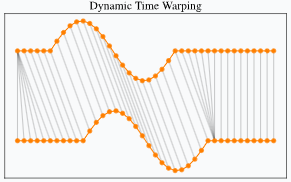

The picture from [4] shows Dynamic type warping distance for a time series. Two time series with different length are being compressed and streched to fit optimally with one another.

fastdtw, an approximate Dynamic Time Warping algorithm, will be used for the dynamic time warping for this project.



#### Average Squared Distance (ASD) 
The ASD is similar to Euclidean distance, but instead of taking the square root of the sum of the squared differences, the sum of the squared differences is calculated and divided by the length of the time series.

##### Formula
Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the ASD distance between the two time series is:

$$ASD(X, Y) = \frac{1}{n}\sum_{i=1}^{n} (x_i - y_i)^2$$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

ASD for calculating distances between two arrays can be implemented in python the following way:

In [84]:
# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])

# ASD calculation
def average_squared_distance(X, Y):
    return np.mean((X - Y) ** 2)

asd = average_squared_distance(X, Y)

print("Average Squared Distance:", asd)

Average Squared Distance: 5.0


Given the same two series as in the euclidean distance, it can be seen that the results differ. Outliers are more impactful in ASD.

CID accounts for the complexity of time series. This could be the volatility of two time series, where they have similar values but move differently. The goal of CID is to adjust the distance measure so that time series with similar complexity are considered closer, even if their raw distances (for example, Euclidean) differ.

It uses, let's say euclidean distance of two time series, and introduces a correction factor, making them complexity-invariant.

##### Formula

Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the CID distance between the two time series is:

$$CID(X,Y)= ED(X,Y) \times CF(X,Y)$$

- $ED(X,Y)$ Calculates euclidean distance between time series X and Y.
- $CF(X,Y)$ is the complexity correction factor.

The correction factor can be defined as followed:

$$CF(X,Y) = \frac{max(CE(X),CE(Y))}{min(CE(X),CE(Y))}$$

This includes CE(Q), which is the complexity estimates of a time series. 

$$ CE(Q) = \sqrt{\sum_{i=1}^{n-1} (q_i - q_{i+1})^2} $$

Here Q is a placeholder for the time series X and Y, since this formula looks at each individual time series.

So $CE()$ calculates the interval volatility/variation of a single time series, whereas $CF()$ compares the complexities, the volatilities, of the two time series.

- If $CE(X)$ is similar to $CE(Y)$: The ratio $\frac{max(CE(X),CE(Y))}{min(CE(X),CE(Y))}$ will be close to 1, and CID(X,Y) will be approximately equal to ED(X,Y). 
In this case, the complexity of the two series is similar, so the standard Euclidean distance is a reasonable measure.
- If $CE(X)$ is significantly different from $CE(Y)$: The ratio will be greater than 1, increasing the CID(X,Y) compared to ED(X,Y). This penalizes distances between time series with different complexity, ensuring that smooth vs. highly volatile series are recognized as fundamentally different.

Unlike raw Euclidean distance, CID helps compare time series fairly when they have different levels of complexity, which is very useful when comparing stocks with different volatilities etc...

CID for calculating distances between two arrays can be implemented in python the following way:

In [85]:
# Defining two series
X = np.array([3, 4, 5, 6])
Y = np.array([6, 5, 4, 3])


# Complexity Estimate (CE) function
def complexity_estimate(series):
    return np.sqrt(np.sum(np.diff(series) ** 2))

# Complexity Factor (CF) function
def complexity_factor(X, Y):
    CE_X = complexity_estimate(X)
    CE_Y = complexity_estimate(Y)
    return max(CE_X, CE_Y) / min(CE_X, CE_Y)

# CID function
def CID(X, Y):
    ED = euclidean_distance(X, Y)  # Euclidean Distance (one from previous example of euclidean metric)
    CF = complexity_factor(X, Y)   # Calculate Complexity Factor
    return ED * CF  # return product

# Calculating CID for X and Y
cid_value = CID(X, Y)
print("CID:", cid_value)
euc_value=euclidean_distance(X, Y) 
print("Euclidean Distance:", euc_value)

CID: 4.47213595499958
Euclidean Distance: 4.47213595499958


In this case, both the Euclidean Distance (ED) and the Complexity-Invariant Distance (CID) return the same value. This happens because the volatility (or complexity) of X and Y is identical, meaning the Complexity Factor (CF) equals 1.
Changing the value of an element in the array X will make the volatility differ between the two arrays.

In [86]:
# Defining two series
X = np.array([12, 4, 5, 6])
Y = np.array([6, 5, 4, 3])


# Calculating CID for new X and Y, where volatility is higher
cid_value = CID(X, Y)
print("CID:", cid_value)
euc_value=euclidean_distance(X, Y)
print("Euclidean Distance:", euc_value)

CID: 32.155870381627054
Euclidean Distance: 6.855654600401044


In the second example, the CID value sees a large increase compared to euclidean distance because the volatility (complexity) of the time series X is now higher than before.

For the KNN usage of these metrics, it pretty much uses the same functions described above. There are though some differences due to error handling being applied some places. 

- Euclidean Distance: This metric is not explicitly displayed here, as the KNN algorithm has a built-in function for computing Euclidean distance, making a separate implementation unnecessary.
- Dynamic Time Warping (DTW): As previously mentioned, the FastDTW library is used for DTW-based predictions. FastDTW is an optimized version of traditional DTW, offering significant improvements in computational efficiency while still preserving accuracy. 
- Average Squared Distance (ASD): This metric is implemented as previously shown
- Complexity-Invariant Distance (CID): Implemented as previously shown, with the exception that error handling is added for volatility of 0. For example, the array X=[3,3,3] would have a min $min(ce_x, ce_y)$ of 0. The safeguard is there to make sure it does not divide by 0.

In [87]:
def dtw_metric(x, y):
    distance, _ = fastdtw(x, y)
    return distance

fastdtw returns a tuple constisting of distance and path. The path isn't interesting...

In [88]:
def asd_metric(x, y):
    return np.mean((x - y) ** 2)

Same as before

In [89]:
# Complexity Estimate (CE) function
def complexity_estimate(series):
    return np.sqrt(np.sum(np.diff(series) ** 2))

# Complexity Factor (CF) function
def complexity_factor(X, Y):
    CE_X = complexity_estimate(X)
    CE_Y = complexity_estimate(Y)
    if min(CE_X, CE_Y) == 0: # safeguard against division by zero
        return 1.0
    return max(CE_X, CE_Y) / min(CE_X, CE_Y)

# CID function
def cid_metric(X, Y):
    ED = euclidean_distance(X, Y)  
    CF = complexity_factor(X, Y)   
    return ED * CF  

Added safeguard

### KNN Forecasting Algorithm

#### Parameters
As mentioned, KNN finds the nearest neighbors to the data you are trying to predict, in this case a part of a time series. To implement it, the following parameters are needed:

- **series**: The time series data on which the forecast will be made. 
- **window_size (default 240)**: Defines the size of the historical window from which the nearest neighbors will be drawn. It controls how many past data points are considered when finding similar patterns.
- **embed_size (default 15)**: The size of the embedding window. It represents the length of the time series subsequence used for each neighbor comparison.
- **k (default 20)**: The number of nearest neighbors used to generate the prediction.
- **metric**: The distance metric used to calculate the "closeness" of the neighbors.

#### Algorithm Overview
The algorithm operates by sliding a window over the time series data, extracting subsequences of a fixed length (embed_size). These subsequences are compared to previous patterns found within a larger historical window (window_size). The similarity between subsequences is determined using a specified distance metric, such as ASD, CID, DTW, or Euclidean distance.

For each prediction step, the algorithm follows these key steps:

1. **Extract the Query:**

- A query subsequence of length $ m $ (where $ m = \text{embed\_size}$ ) is extracted from the current time series data. This subsequence represents the recent historical pattern before the point being predicted.

- Mathematically, the query subsequence $ Q $ at time $ t $ is defined as:

  $$
  Q_t = [X_{t-m}, X_{t-m+1}, ..., X_{t-1}]
  $$

  where $ X_t $ represents the time series values at time step $ t $ in which you want to predict, and the subsequence consists of the last $ m $ values before $ t $.

2. **Extract the historical window:**
- The historical window consists of all past time series values up to the point where the prediction is being made, excluding the query subsequence. It is used to find similar patterns in past data.

- Mathematically, the historical window $H_t$ at time $t$ is defined as:

  $$
  H_t = [X_0, X_1, ..., X_{t-m-1}]
  $$

  where $X_t$ represents the time series values at time step $t$, and the historical window consists of all past values up to $t - m - 1$. 

  - Essentially, it looks before the embed size and one extra index, since that is the one you are trying to predict

3. **Ensure Sufficient Data for Prediction:**

- If the available historical data is less than window_size, a placeholder value (zero) is appended to the predictions, and the algorithm moves to the next step.

4. **Generate Historical Embeddings:**

- From the historical window, we extract overlapping subsequences of length $m$ (where $m = \text{embed\_size}$). These subsequences serve as the basis for identifying similar patterns.

- Since the historical window does not always start at $t - w$, the valid starting index $j$ is determined as:

  $$
  j_{\text{start}} = \max(0, t - w)
  $$

  ensuring that we do not exceed available historical data.

- Each subsequence is then defined as:

  $$
  S_j = [X_j, X_{j+1}, ..., X_{j+m-1}], \quad \forall j \in [j_{\text{start}}, t - m]
  $$

  where:
  - $w$ (window size) determines the **maximum** lookback period.
  - $j$ iterates over valid indices in the historical window, ensuring we extract all possible subsequences of length $m$.

5. **Find the Nearest Neighbors:**

- K-Nearest Neighbors model is initialized with k neighbors, using the selected distance metric. The model is an instance of the NearestNeighbors class from the sklearn.neighbors module from the scikit-learn library.

- The historical embeddings are fitted to this model.

- The algorithm finds the k closest subsequences, which represent the most similar patterns to the query.

6. **Extract Corresponding Future Values:**

- Once the nearest neighbors are identified, the algorithm retrieves the actual values that immediately follow each matched subsequence.

7. **Compute the Weighted Average Prediction:**

- The forecast is obtained by computing a weighted average of the retrieved values.

- Let the predicted value be $ \hat{y}_t $, which is the weighted average of the future values $ y_{t+k} $ corresponding to the k nearest neighbors:

  $$
  \hat{y}_t = \frac{\sum_{i=1}^{k} w_i \cdot y_{t+k_i}}{\sum_{i=1}^{k} w_i}
  $$

  where:
  - $ w_i = \frac{1}{d_i + \epsilon} $ is the weight for each neighbor, with $d_i$ being the distance between the query subsequence and the $i$-th neighbor, and $\epsilon$ is a small constant added to avoid division by zero.
  - $ y_{t+k_i} $ is the future value corresponding to the $i$-th nearest neighbor.
  - $ k $ is the number of nearest neighbors.

8. **Store the Prediction and Move Forward:**

- The computed prediction is appended to the results list.

- The process continues until predictions have been made for all possible points in the time series.

9. **Return the Final Predictions:**

- The function returns a list of predictions, ensuring that the initial part of the series (where predictions couldn't be made) is filled with zeros to maintain alignment with the original time series.

#### Python Implementation
Below is the python implementation for the algorithm

In [90]:
def knn_forecast(series, window_size=240, embed_size=15, k=20, metric=dtw_metric): # Default values for window_size, embed_size, k, and metric.
    predictions = []
    for i in range(window_size + embed_size, len(series)):
        query = series.iloc[i - embed_size:i].values #query of what is being predicted.
        history = series.iloc[:i - embed_size].values # historical window up to what is being predicted.
        
        if len(history) < window_size: # if there is not enough data to make a prediction.
            predictions.append(0) # If not enough data, append 0 as a placeholder prediction.
            continue
        
        
        start_index = max(0, len(history) - window_size) # Start index to ensure the available data is not exceeded
        historical_embeddings = np.array([history[j:j + embed_size] for j in range(start_index, len(history) - embed_size + 1)]) # This generates subsequences of length 'embed_size' starting from each position in the historical data.
        
        # Initialize NearestNeighbors object to find k nearest neighbors using the specified metric.
        nbrs = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1) #n_jobs=-1 to use all available CPU cores.
        nbrs.fit(historical_embeddings)  # Fits model to the historical subsequences.

        # Find the nearest neighbors to the current query.
        dist, indices = nbrs.kneighbors([query])  # Get distances and indices of the nearest neighbors to the query.

        # Get the actual returns corresponding to the k nearest neighbors from the indices.
        next_returns = [series.iloc[start_index + idx + embed_size] for idx in indices[0]]

        # Calculate the weights for each neighbor, inverse of the distance (small epsilon added to avoid division by zero).
        weights = 1 / (dist[0] + 1e-6)

        # Calculate the weighted average of the next returns to make the prediction.
        prediction = np.average(next_returns, weights=weights)

        # Append the prediction to the results list.
        predictions.append(prediction)

    # Return the final predictions, adding zeros for the initial part of the series where predictions aren't made.
    return [0] * (window_size + embed_size) + predictions

Running the forecast for the 4 different distance metrics, storing results as columns in dataframe:

In [ ]:
df["knn_euc_pred"] = knn_forecast(df["std_ema_returns"], metric="euclidean")
df["knn_dtw_pred"] = knn_forecast(df["std_ema_returns"], metric=dtw_metric)
df["knn_asd_pred"] = knn_forecast(df["std_ema_returns"], metric=asd_metric)
df["knn_cid_pred"] = knn_forecast(df["std_ema_returns"], metric=cid_metric)



### Forecast results

The results of the algorithm are stored as columns in the dataframe

In [127]:
print(df[["knn_euc_pred", "knn_dtw_pred", "knn_asd_pred", "knn_cid_pred"]].tail())

                     knn_euc_pred  knn_dtw_pred  knn_asd_pred  knn_cid_pred
Time                                                                       
2021-03-31 16:55:00      0.024390     -0.072528     -0.015807     -0.165115
2021-03-31 17:00:00     -0.552430     -0.271599     -0.526646     -0.317540
2021-03-31 17:05:00     -0.442047     -0.330582     -0.452102     -0.385247
2021-03-31 17:10:00     -0.411779     -0.339745     -0.444811     -0.389048
2021-03-31 17:15:00     -0.438936     -0.344735     -0.459552     -0.345706


The tail of output for the forecast with parameters:
start_date = "2021-03-01 00:00"
end_date = "2021-03-31 17:15"
window_size=240, embed_size=15, k=20

| Time                      | knn_euc_pred | knn_dtw_pred | knn_asd_pred | knn_cid_pred |
|---------------------------|--------------|--------------|--------------|--------------|
| 2021-03-31 16:55:00       | 0.024390     | -0.072528    | -0.015807    | -0.165115    |
| 2021-03-31 17:00:00       | -0.552430    | -0.271599    | -0.526646    | -0.317540    |
| 2021-03-31 17:05:00       | -0.442047    | -0.330582    | -0.452102    | -0.385247    |
| 2021-03-31 17:10:00       | -0.411779    | -0.339745    | -0.444811    | -0.389048    |
| 2021-03-31 17:15:00       | -0.438936    | -0.344735    | -0.459552    | -0.345706    |

The comparison between the predicted standardized EMA returns and the actual standardized EMA returns can be seen in the plot below:

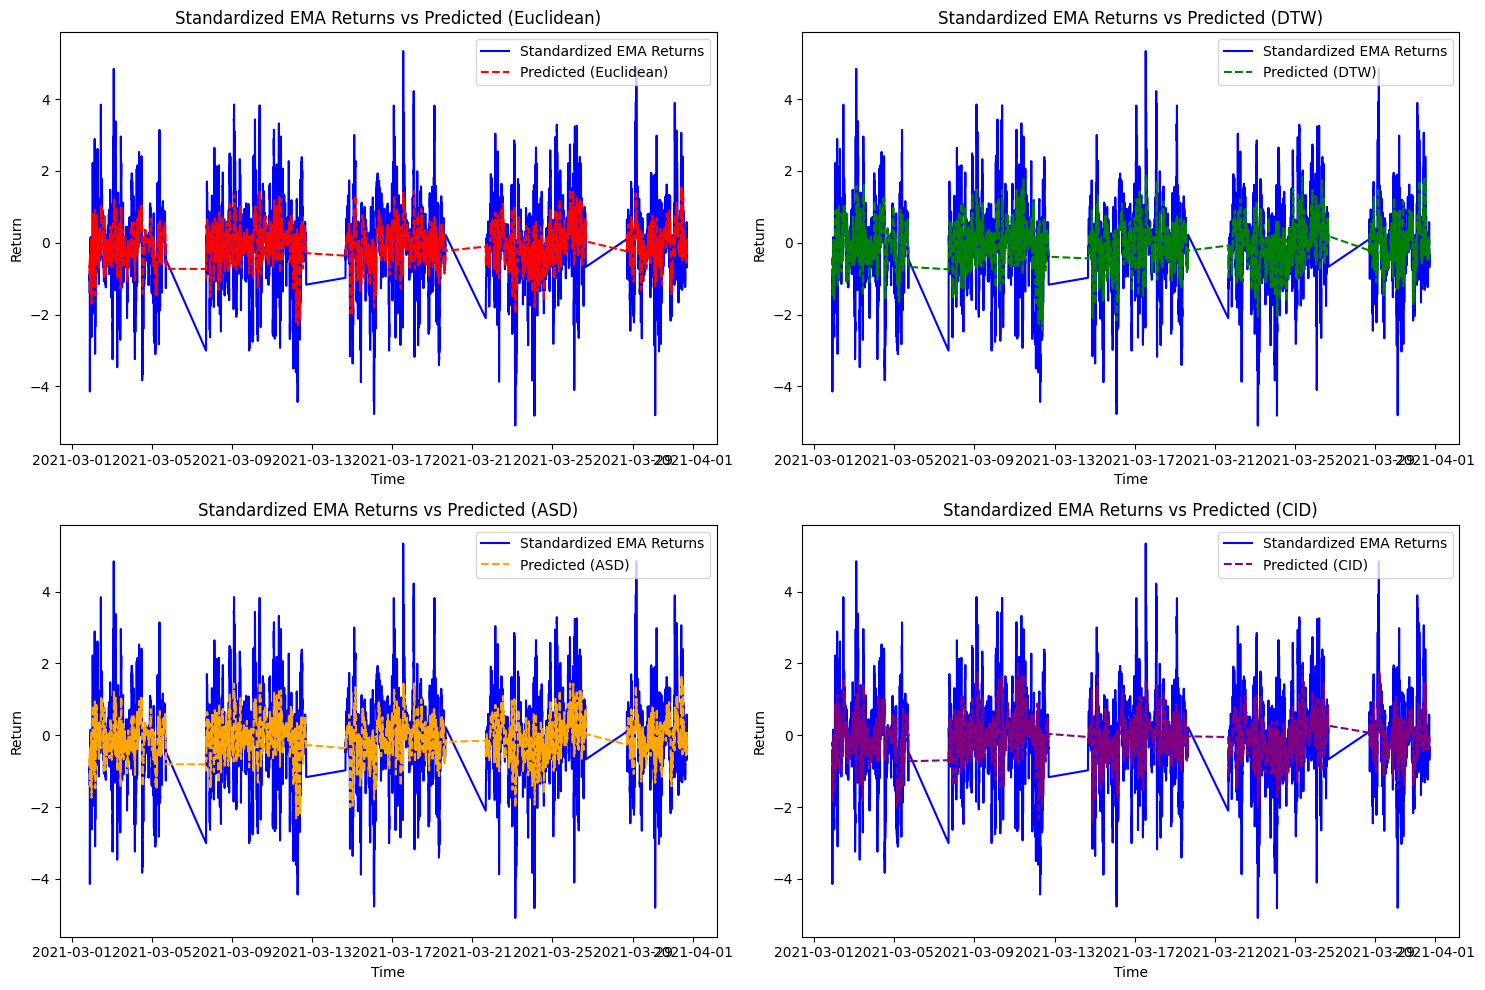

In [128]:
import matplotlib.pyplot as plt

# Slice the DataFrame to only include data after index 255
df_subset = df.iloc[256:]

# Create a 2x2 grid for subplots (2 rows and 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Graph 1: Predicted vs Standardized EMA Returns (ASD)
axes[0, 0].plot(df_subset['std_ema_returns'], label='Standardized EMA Returns', color='blue')
axes[0, 0].plot(df_subset['knn_euc_pred'], label='Predicted (Euclidean)', color='red', linestyle='--')
axes[0, 0].set_title('Standardized EMA Returns vs Predicted (Euclidean)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Return')
axes[0, 0].legend()

# Graph 2: Predicted vs Standardized EMA Returns (CID)
axes[0, 1].plot(df_subset['std_ema_returns'], label='Standardized EMA Returns', color='blue')
axes[0, 1].plot(df_subset['knn_dtw_pred'], label='Predicted (DTW)', color='green', linestyle='--')
axes[0, 1].set_title('Standardized EMA Returns vs Predicted (DTW)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Return')
axes[0, 1].legend()

# Graph 3: Predicted vs Standardized EMA Returns (DTW)
axes[1, 0].plot(df_subset['std_ema_returns'], label='Standardized EMA Returns', color='blue')
axes[1, 0].plot(df_subset['knn_asd_pred'], label='Predicted (ASD)', color='orange', linestyle='--')
axes[1, 0].set_title('Standardized EMA Returns vs Predicted (ASD)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Return')
axes[1, 0].legend()

# Graph 4: Predicted vs Standardized EMA Returns (Euclidean)
axes[1, 1].plot(df_subset['std_ema_returns'], label='Standardized EMA Returns', color='blue')
axes[1, 1].plot(df_subset['knn_cid_pred'], label='Predicted (CID)', color='purple', linestyle='--')
axes[1, 1].set_title('Standardized EMA Returns vs Predicted (CID)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Return')
axes[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


#### Error Metric for Predicting Volatility-Adjusted Returns

Several error metrics can be used to assess the accuracy of the algorithm's predictions of volatility-adjusted returns. These metrics provide different perspectives on the algorithm's performance and offer insights into how well it can generalize to unseen data. The following error metrics are employed:


The Mean Absolute Error (MAE) calculates the average of the absolute differences between the actual and predicted returns. Unlike MSE, MAE gives equal weight to all errors, regardless of their size. This makes MAE a useful metric when you want to evaluate the average magnitude of errors without giving excessive importance to large deviations. A lower MAE indicates better performance, and it is less sensitive to outliers compared to MSE.

**Formula:**
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

In [129]:
y_actual = df['std_ema_returns'].iloc[256:].values  # Data after index 255
y_pred_euc = df['knn_euc_pred'].iloc[256:].values
y_pred_dtw = df['knn_dtw_pred'].iloc[256:].values
y_pred_asd = df['knn_asd_pred'].iloc[256:].values
y_pred_cid = df['knn_cid_pred'].iloc[256:].values


# Function to calculate MAE
def calculate_mae(actual, predicted):
    # Initialize the sum of absolute errors
    total_error = 0
    
    # Loop through each index and calculate the absolute error
    for i in range(len(actual)):
        total_error += abs(actual[i] - predicted[i])
    
    # Calculate the mean absolute error
    mae = total_error / len(actual)
    return mae

# Calculate MAE for each of the predictions
mae_euc = calculate_mae(y_actual, y_pred_euc)
mae_dtw = calculate_mae(y_actual, y_pred_dtw)
mae_asd = calculate_mae(y_actual, y_pred_asd)
mae_cid = calculate_mae(y_actual, y_pred_cid)

# Print the MAE results
print(f"Mean Absolute Error (MAE) - Euclidean: {mae_euc}")
print(f"Mean Absolute Error (MAE) - DTW: {mae_dtw}")
print(f"Mean Absolute Error (MAE) - ASD: {mae_asd}")
print(f"Mean Absolute Error (MAE) - CID: {mae_cid}")


Mean Absolute Error (MAE) - Euclidean: 0.6514563782014153
Mean Absolute Error (MAE) - DTW: 0.6182382663325854
Mean Absolute Error (MAE) - ASD: 0.6492510461342019
Mean Absolute Error (MAE) - CID: 0.7017119531893139


| Distance Metric | MAE     |
|-----------------|---------|
| Euclidean       | 0.6515  |
| DTW             | 0.6182  |
| ASD             | 0.6493  |
| CID             | 0.7017  |

it can be seen that DTW has the lowest MAE, while CID has the highest. Cool thing to notice is that it is almost the same for Euclidean and ASD. They are almost calculated identically, so this makes sense. Also notice how it is true (they are very close) for all of the error metrics.

To check if the MAE of the model is actually good,below is a plot showing the MAE vs the standard deviation of the standardized returns. The standard deviation of std_ema_returns represents the natural variability in the data. If the MAE values are significantly lower than the standard deviation, it suggests the model is making meaningful predictions rather than random guesses.


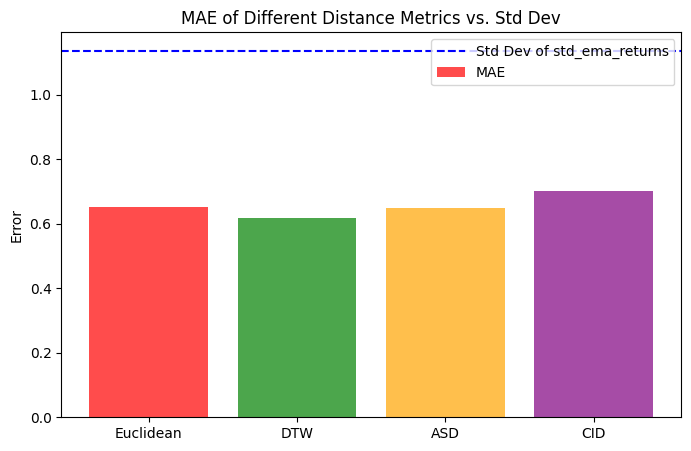

In [ ]:
# MAE values for different distance metrics
mae_values = {'Euclidean': mae_euc,'DTW': mae_dtw,'ASD': mae_asd,'CID': mae_cid}

std_value = df['std_ema_returns'].std()  # Standard deviation of std_ema_returns

# Plot MAE values
plt.figure(figsize=(8, 5))
plt.bar(mae_values.keys(), mae_values.values(), color=['red', 'green', 'orange', 'purple'], alpha=0.7, label="MAE")

# Add a horizontal line for the standard deviation
plt.axhline(y=std_value, color='blue', linestyle='--', label="Std Dev of std_ema_returns")

# Labels and title
plt.ylabel("Error")
plt.title("MAE of Different Distance Metrics vs. Std Dev")
plt.legend()
plt.show()


It can be seen that KNN forecasts for all distance metrics are well below the baseline for the standard deviation of std_ema_returns, suggesting that the KNN algorithm has effectively captured the underlying patterns and volatility in the data.

##### 2. Mean Squared Error (MSE)

The Mean Squared Error (MSE) calculates the average of the squared differences between the actual and predicted returns. Unlike MAE, MSE gives more weight to larger errors due to the squaring of the differences. This can be useful when the model needs to penalize large deviations more heavily. A lower MSE indicates better performance, but it is sensitive to outliers. [6]

**Formula:**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

In [136]:
def calculate_mse(actual, predicted):
    # Initialize the sum of squared errors
    total_error = 0
    
    # Loop through each index and calculate the squared error
    for i in range(len(actual)):
        total_error += (actual[i] - predicted[i]) ** 2
    
    # Calculate the mean squared error
    mse = total_error / len(actual)
    return mse

# Calculate MSE for each of the predictions
mse_euc = calculate_mse(y_actual, y_pred_euc)
mse_dtw = calculate_mse(y_actual, y_pred_dtw)
mse_asd = calculate_mse(y_actual, y_pred_asd)
mse_cid = calculate_mse(y_actual, y_pred_cid)
# Print the MSE results
print(f"Mean Squared Error (MSE) - Euclidean: {mse_euc}")
print(f"Mean Squared Error (MSE) - DTW: {mse_dtw}")
print(f"Mean Squared Error (MSE) - ASD: {mse_asd}")
print(f"Mean Squared Error (MSE) - CID: {mse_cid}")



Mean Squared Error (MSE) - Euclidean: 0.7916127311823237
Mean Squared Error (MSE) - DTW: 0.7302755747426088
Mean Squared Error (MSE) - ASD: 0.7861720142025952
Mean Squared Error (MSE) - CID: 0.9473407319003361


| Distance Metric | MSE      |
|-----------------|----------|
| Euclidean       | 0.7916   |
| DTW             | 0.7303   |
| ASD             | 0.7862   |
| CID             | 0.9473   |

it can be seen that DTW has the lowest MSE, while CID has the highest.

Below is a plot showing the MSE vs the squared standard deviation of the standardized returns. The squared standard deviation of std_ema_returns represents the natural variability in the data. If the MSE values are significantly lower than the squared standard deviation, it suggests the model is making meaningful predictions rather than random guesses.

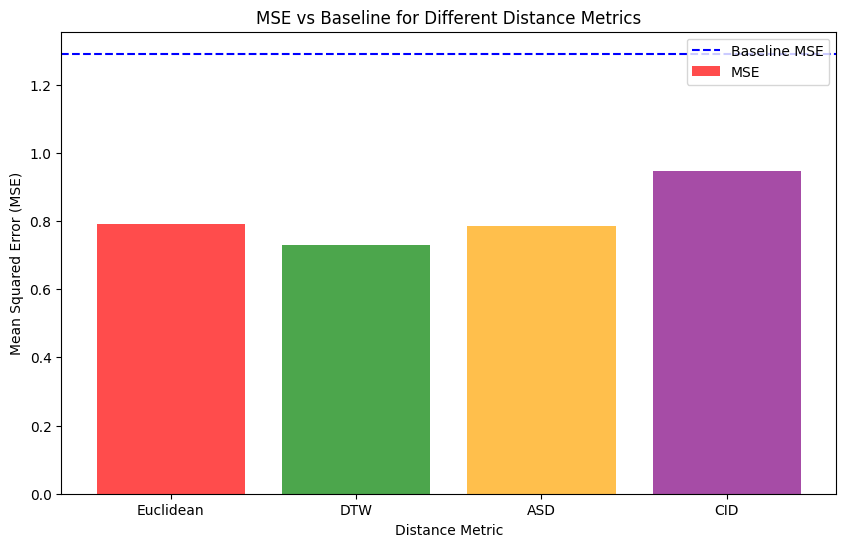

In [142]:
mse_values = {'Euclidean': mse_euc,'DTW': mse_dtw,'ASD': mse_asd,'CID': mse_cid}

# Baseline MSE (mean of actual values)
baseline_mse = df['std_ema_returns'].std() ** 2

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(mse_values.keys(), mse_values.values(), color=['red', 'green', 'orange', 'purple'], alpha=0.7, label="MSE")
plt.axhline(y=baseline_mse, color='b', linestyle='--', label="Baseline MSE")
plt.xlabel('Distance Metric')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Baseline for Different Distance Metrics')
plt.legend()
plt.show()

It can be seen that KNN forecasts for all distance metrics are well below the baseline for the standard deviation of the standardized EMA returns squared, suggesting that the KNN algorithm has effectively captured the underlying patterns and volatility in the data.

##### 3. Root Mean Squared Error (RMSE)

The Root Mean Squared Error (RMSE) is the square root of the Mean Squared Error. RMSE provides an error metric that is in the same units as the target variable, making it more interpretable than MSE. Like MSE, RMSE is sensitive to large errors, and thus it can be useful when the model needs to give higher penalties to larger prediction errors. A lower RMSE indicates better performance. [6]

**Formula:**
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$
Where:
- $y_i$ is the actual returns
- $\hat{y}_i$ is the predicted returns
- $n$ is the number of observations

In [140]:
def calculate_rmse(actual, predicted):
    # First, calculate MSE
    total_error = 0
    for i in range(len(actual)):
        total_error += (actual[i] - predicted[i]) ** 2
    
    mse = total_error / len(actual)
    
    # Take the square root of MSE to get RMSE
    rmse = math.sqrt(mse)
    return rmse

# Calculate RMSE for each of the predictions
rmse_euc = calculate_rmse(y_actual, y_pred_euc)
rmse_dtw = calculate_rmse(y_actual, y_pred_dtw)
rmse_asd = calculate_rmse(y_actual, y_pred_asd)
rmse_cid = calculate_rmse(y_actual, y_pred_cid)

# Print the RMSE results
print(f"Root Mean Squared Error (RMSE) - Euclidean: {rmse_euc}")
print(f"Root Mean Squared Error (RMSE) - DTW: {rmse_dtw}")
print(f"Root Mean Squared Error (RMSE) - ASD: {rmse_asd}")
print(f"Root Mean Squared Error (RMSE) - CID: {rmse_cid}")


Root Mean Squared Error (RMSE) - Euclidean: 0.8897262113607329
Root Mean Squared Error (RMSE) - DTW: 0.8545616272350455
Root Mean Squared Error (RMSE) - ASD: 0.8866634165243287
Root Mean Squared Error (RMSE) - CID: 0.9733143027307962


| Distance Metric | RMSE     |
|-----------------|----------|
| Euclidean       | 0.8897   |
| DTW             | 0.8546   |
| ASD             | 0.8867   |
| CID             | 0.9733   |

It can be seen that DTW has the lowest RMSE, while CID has the highest.

Below is a plot showing the RMSE vs the squared standard deviation of the standardized returns. The squared standard deviation of the standardized EMA returns represents the natural variability in the data. If the RMSE values are significantly lower than the squared standard deviation, it suggests that the model is making meaningful predictions, capturing the underlying patterns in the data, rather than simply random guesses.

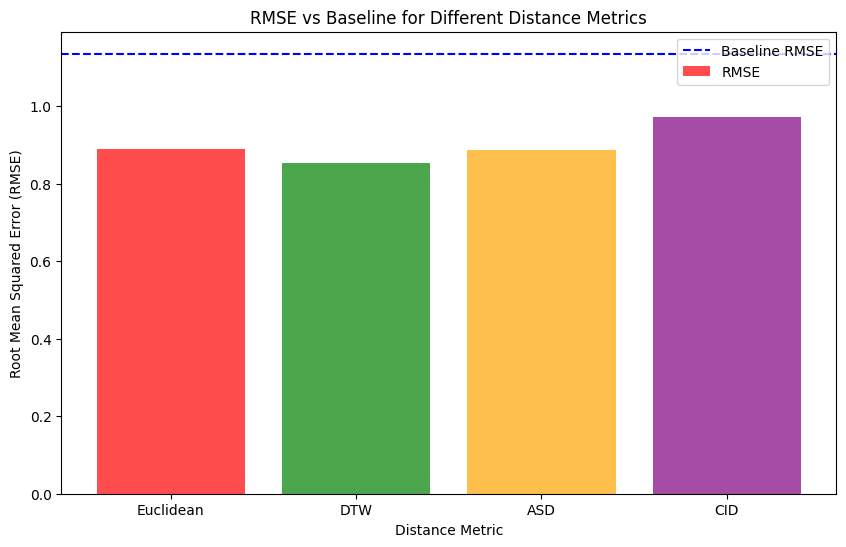

In [147]:
rmse_values = {'Euclidean': rmse_euc,'DTW': rmse_dtw,'ASD': rmse_asd,'CID': rmse_cid}

# Baseline RMSE (mean of actual values)
mean_std_ema_return = df['std_ema_returns'].mean()
baseline_predictions_std_ema = np.full(len(df['std_ema_returns']), mean_std_ema_return)
baseline_rmse_std_ema = np.sqrt(mean_squared_error(df['std_ema_returns'], baseline_predictions_std_ema))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['red', 'green', 'orange', 'purple'], alpha=0.7, label="RMSE")
plt.axhline(y=baseline_rmse_std_ema, color='b', linestyle='--', label="Baseline RMSE")
plt.xlabel('Distance Metric')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs Baseline for Different Distance Metrics')
plt.legend()
plt.show()

All of the forecasts with different metrics outperform the baseline, indicating that they are providing meaningful forecasting of the standardized returns.

##### 4. Normalized Mean Absolute Error (NMAE)

The Normalized Mean Absolute Error (NMAE) is a variant of MAE that is normalized by the range of the actual values. It provides a scale-independent measure of error, which is useful when comparing performance across different datasets or models with different magnitudes. The lower the NMAE, the better the model performs in predicting volatility-adjusted returns, relative to the range of the returns.

**Formula:**
$$
\text{NMAE} = \frac{\text{MAE}}{\text{max}(y) - \text{min}(y)}
$$
Where:
- $\text{MAE}$ is the Mean Absolute Error
- $\text{max}(y)$ is the maximum value of the returns
- $\text{min}(y)$ is the minimum value of the returns

In [145]:
def nmae(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    range_y = np.max(y_true) - np.min(y_true)
    return mae / range_y if range_y != 0 else mae  # Avoids division by zero

nmae_euc = nmae(df["std_ema_returns"], df["knn_euc_pred"])
nmae_dtw = nmae(df["std_ema_returns"], df["knn_dtw_pred"])
nmae_asd = nmae(df["std_ema_returns"], df["knn_asd_pred"])
nmae_cid = nmae(df["std_ema_returns"], df["knn_cid_pred"])

print(f"NMAE (Euclidean Metric): {nmae_euc:.4f}")
print(f"NMAE (DTW Metric): {nmae_dtw:.4f}")
print(f"NMAE (ASD Metric): {nmae_asd:.4f}")
print(f"NMAE (CID Metric): {nmae_cid:.4f}")

NMAE (Euclidean Metric): 0.0633
NMAE (DTW Metric): 0.0602
NMAE (ASD Metric): 0.0631
NMAE (CID Metric): 0.0679


| Distance Metric | NMAE    |
|-----------------|---------|
| Euclidean       | 0.0633  |
| DTW             | 0.0602  |
| ASD             | 0.0631  |
| CID             | 0.0679  |

It can be seen that DTW has the lowest NMAE, indicating that it is the most accurate metric relative to the range of the actual returns.



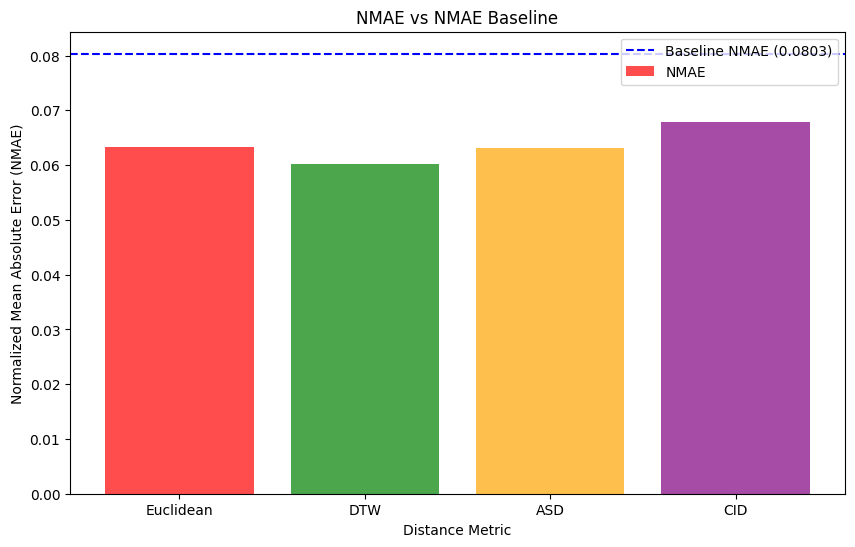

In [146]:
nmae_values = {'Euclidean': nmae_euc, 'DTW': nmae_dtw,'ASD': nmae_asd,'CID': nmae_cid}


mean_std_ema_return = df['std_ema_returns'].mean()  # Mean of the actual values
baseline_predictions_std_ema = np.full(len(df['std_ema_returns']), mean_std_ema_return)  # Baseline model predictions (constant mean value)
baseline_nmae_std_ema = mean_absolute_error(df['std_ema_returns'], baseline_predictions_std_ema) / (df['std_ema_returns'].max() - df['std_ema_returns'].min())  # Normalized MAE

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(nmae_values.keys(), nmae_values.values(), color=['red', 'green', 'orange', 'purple'], alpha=0.7, label="NMAE")
plt.axhline(y=baseline_nmae_std_ema, color='b', linestyle='--', label=f"Baseline NMAE ({baseline_nmae_std_ema:.4f})")
plt.xlabel('Distance Metric')
plt.ylabel('Normalized Mean Absolute Error (NMAE)')
plt.title('NMAE vs NMAE Baseline')
plt.legend()

All of the model predictions are below the NMAE baseline.

All in all, based on the different error metrics, there are strong indications that the model is good at predicted standardized EMA returns.

What can that be used for, one might ask. In comes the backtest.

## Simple Backtest of Forecast Predictions

### Backtest Strategy

## Results and Visualization

## Conclusion

## References
[1] James Chen. (2024). [What is EMA? How to Use Exponential Moving Average With Formula](https://www.investopedia.com/terms/e/ema.asp)

[2] G. E. A. P. A. Batista, X. Wang, and E. J. Keogh, "A Complexity-Invariant Distance Measure for Time Series,"

[3] GeeksForGeeks (2023). [Similarity Search for Time-Series Data](https://www.geeksforgeeks.org/similarity-search-for-time-series-data/)

[4] Romain Tavenard [An introduction to Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html)

[5] GeeksForGeeks (2024). [Dynamic Time Warping (DTW) in Time Series](https://www.geeksforgeeks.org/dynamic-time-warping-dtw-in-time-series/)

[6] jedox. [Error Metrics: How to Evaluate Your Forecasts](https://www.jedox.com/en/blog/error-metrics-how-to-evaluate-forecasts/)